# Background
Physiological and laboratory data provided in collaboration with MIT’s GOSSIS community initiative (e.g., blood pressure, heart rate, glucose levels, lactate levels) collected in the first 24 hours of ICU admission are critical indicators of a patient’s condition. 

# Objective

To accurate predict the mortality in the 1st 24 hrs following admission to an Intensive Care Unit (ICU).

# Research Quesiton

1) To determine whether deep learning models can effectively predict ICU mortality using these early indicators and Identify which features are most influential in the prediction.
2) How does model performance compare to traditional clinical scoring systems (apache_4a_hospital_death_prob, apache_4a_icu_death_prob) for ICU mortality prediction?

# Dataset
The dataset contains records collected over the course of a year from over 91,000 intensive care unit (ICU) visits at various hospitals.
It has 91,713 records and 186 columns. 

Target variable : hospital_death 

### Import Necessary Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

import seaborn as sns
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

#Use this if you are running the code on Colab
from google.colab import files
import io

uploaded = files.upload()

In [2]:
source_df = pd.read_csv('dataset/Datathon #3 Dataset - HAD7001.csv')
print(source_df.shape)
dict_df = pd.read_csv('dataset/Datathon #3 Data Dictionary - HAD7001.csv')
dict_df.Category.value_counts()

(91713, 186)


Category
labs                         60
vitals                       52
APACHE covariate             28
demographic                  16
labs blood gas               16
APACHE comorbidity            8
identifier                    3
APACHE prediction             2
APACHE grouping               2
GOSSIS example prediction     1
Name: count, dtype: int64

In [74]:
def print_classification_report(model_results):
    for model_name, metrics in model_results.items():
        # Extract metrics
        accuracy = metrics['Accuracy']
        precision_0 = metrics['Precision (Survived 0)']
        recall_0 = metrics['Recall (Survived 0)']
        f1_0 = metrics['F1-score (Survived 0)']
        precision_1 = metrics['Precision (Death 1)']
        recall_1 = metrics['Recall (Death 1)']
        f1_1 = metrics['F1-score (Death 1)']
        cm = metrics['Confusion Matrix']  

        support_0 = cm[0][0] + cm[0][1] 
        support_1 = cm[1][0] + cm[1][1]  
        total_support = support_0 + support_1

        macro_precision = (precision_0 + precision_1) / 2
        macro_recall = (recall_0 + recall_1) / 2
        macro_f1 = (f1_0 + f1_1) / 2

        weighted_precision = (precision_0 * support_0 + precision_1 * support_1) / total_support
        weighted_recall = (recall_0 * support_0 + recall_1 * support_1) / total_support
        weighted_f1 = (f1_0 * support_0 + f1_1 * support_1) / total_support

        print(f"\n{model_name}")
        print("              precision    recall    f1-score    support")
        print(f"\nSurvived (0)      {precision_0:.2f}       {recall_0:.2f}       {f1_0:.2f}      {support_0}")
        print(f"   Death (1)      {precision_1:.2f}       {recall_1:.2f}       {f1_1:.2f}       {support_1}")
        print(f"\n    accuracy                           {accuracy:.2f}      {total_support}")
        print(f"   macro avg      {macro_precision:.2f}       {macro_recall:.2f}       {macro_f1:.2f}      {total_support}")
        print(f"weighted avg      {weighted_precision:.2f}       {weighted_recall:.2f}       {weighted_f1:.2f}      {total_support}")


## Select factors based on Domain knowledge

In [4]:
demog_vars =  ['age' , 'bmi' , 'ethnicity',  'gender', 'elective_surgery', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression',
'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'pre_icu_los_days', 'icu_admit_source']

# Factors Important for ICU Mortality Prediction in the First 24 Hours
vars_24 =  ['albumin_apache','apace_post_operative','arf_apache','bilirubin_apache','bun_apache','creatinine_apache',
             'fio2_apache','gcs_eyes_apache','gcs_motor_apache', 'gcs_verbal_apache','glucose_apache',  'heart_rate_apache',
               'hematrocrit_apache','intubated_apache','map_apache','paco2_apache','paco2_for_ph_apache','pao2_apache','ph_apache',
               'resprate_apache','sodium_apache', 'temp_apache','urineoutput_apache','wbc_apache']

#icu_vars = ['ventilated_apache, intubated_apache, apache_post_operative']

## Exclude all APACHE related variables

In [5]:
dict_df.Category.value_counts().keys()

Index(['labs', 'vitals', 'APACHE covariate', 'demographic', 'labs blood gas',
       'APACHE comorbidity', 'identifier', 'APACHE prediction',
       'APACHE grouping', 'GOSSIS example prediction'],
      dtype='object', name='Category')

In [6]:
### KEEP it later for benchmark 
hospital_death_apache = source_df['apache_4a_hospital_death_prob']
icu_death_apache = source_df['apache_4a_icu_death_prob']
target_var = 'hospital_death'

In [7]:
exclude_APACHE_cat = [category for category in dict_df.Category.value_counts().keys() if 'APACHE' not in category]
print("Excluding APACHE related variables")
sel_variables = dict_df[dict_df['Category'].isin(exclude_APACHE_cat)]['Variable Name'].tolist()
print('{}  Total varaibles in source_df '.format(len(source_df.columns.tolist())))
print('{}  of varaibles are selected from dict'.format(len(sel_variables)))
### investigate variables inconsistent in the meta info : list(set(source_df.columns.tolist()) - set(sel_variables) )
### Manually added the missing variables in the data dictionary 
to_add = ['aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 
          'leukemia', 'lymphoma','solid_tumor_with_metastasis']
to_remove = list(set(sel_variables) - set(source_df.columns.tolist()))
sel_variables = sel_variables + to_add
sel_variables = list(filter(lambda x: x not in to_remove, sel_variables))
print('{}  of varaibles are selected'.format(len(sel_variables)))

Excluding APACHE related variables
186  Total varaibles in source_df 
148  of varaibles are selected from dict
154  of varaibles are selected


In [8]:
source_df[sel_variables]

,encounter_id,hospital_id,patient_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,66154,118,25312,0,68.0,22.730000,0,Caucasian,M,180.3,...,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,114252,81,59342,0,77.0,27.420000,0,Caucasian,F,160.0,...,51.0,51.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,119783,118,50777,0,25.0,31.950000,0,Caucasian,F,172.7,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,79267,118,46918,0,81.0,22.640000,1,Caucasian,F,165.1,...,337.0,337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,92056,33,34377,0,19.0,NaN,0,Caucasian,M,188.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,30,78108,0,75.0,23.060250,0,Caucasian,M,177.8,...,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
91709,66119,121,13486,0,56.0,47.179671,0,Caucasian,F,183.0,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91710,8981,195,58179,0,48.0,27.236914,0,Caucasian,M,170.2,...,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
91711,33776,66,120598,0,NaN,23.297481,0,Caucasian,F,154.9,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
source_df  = source_df[sel_variables]

In [10]:
p_record_counts = source_df["patient_id"].value_counts()
p_records = p_record_counts[p_record_counts > 1]
print("Find patients with more than one record", len(p_records)) 

p_hospital_counts = source_df.groupby("patient_id")["hospital_id"].nunique()
patients_multiple_hospitals = p_hospital_counts[p_hospital_counts > 1]

p_encounter_counts = source_df.groupby("patient_id")["encounter_id"].nunique()
p_encounters = p_encounter_counts[p_encounter_counts > 1]

p_icu_counts = source_df.groupby("patient_id")["icu_id"].nunique()
p_icu_counters = p_icu_counts[p_icu_counts > 1]

print('Check if patient_id has stayed in more than one hospitals', len(patients_multiple_hospitals))
print("patient_id has more than one encounter", len(p_encounters))
print("patient_id has more than one icu admission", len(p_icu_counters))

Find patients with more than one record 0
Check if patient_id has stayed in more than one hospitals 0
patient_id has more than one encounter 0
patient_id has more than one icu admission 0


In [11]:
source_df.drop(columns=['encounter_id','patient_id','hospital_id' ,'icu_id'] , axis=1, inplace=True)
source_df.head()

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,admit,...,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,admit,...,51.0,51.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,25.0,31.95,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,admit,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,81.0,22.64,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,admit,...,337.0,337.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,admit,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### EDA for feature inspection

In [12]:
# Drop columns with a single unique value
single_value_cols = [col for col in source_df.columns if source_df[col].nunique() == 1]
source_df.drop(columns=single_value_cols, inplace=True)
print('Drop columns with a single unique value')
print(single_value_cols ) 

Drop columns with a single unique value
['readmission_status']


In [13]:
# Convert columns with less than 10 unique values to categorical type
low_unique_cols = [col for col in source_df.columns if source_df[col].nunique() <= 10]
source_df[low_unique_cols] = source_df[low_unique_cols].astype('category')
print('convert them into categorical', low_unique_cols)
print(len(low_unique_cols))

convert them into categorical ['hospital_death', 'elective_surgery', 'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']
15


In [14]:
numerical_vars = source_df.select_dtypes(include=["number"]).columns.tolist()
categorical_vars = source_df.select_dtypes(exclude=["number"]).columns.tolist()
dataset_overview = {
    "Total Rows": source_df.shape[0],
    "Total Columns": source_df.shape[1],
    "Duplicate Rows": source_df.duplicated().sum(),
    "Numerical Column Counts": len(numerical_vars),
    "Categorical Column counts": len(categorical_vars)
}
dataset_overview

{'Total Rows': 91713,
 'Total Columns': 149,
 'Duplicate Rows': np.int64(0),
 'Numerical Column Counts': 133,
 'Categorical Column counts': 16}

In [15]:
description = source_df.describe()
description

,age,bmi,height,pre_icu_los_days,weight,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,...,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min
count,87485.000000,88284.000000,90379.000000,91713.000000,88993.000000,23729.000000,23729.000000,91548.000000,91548.000000,90673.000000,...,25705.000000,25705.000000,15754.000000,15754.000000,15289.000000,15289.000000,15768.000000,15768.000000,11518.000000,11518.000000
mean,62.309516,29.185818,169.641588,0.835766,84.028340,78.757006,46.738253,88.491873,50.161314,88.610513,...,285.667079,223.523037,44.668444,43.383453,7.338363,7.327883,163.841354,144.154224,244.404982,235.933050
std,16.775119,8.275142,10.795378,2.487756,25.011497,21.725389,12.855733,19.798379,13.317586,19.793743,...,128.218956,117.552497,14.630907,14.113107,0.105821,0.107873,113.455738,98.464543,129.964308,126.458507
min,16.000000,14.844926,137.200000,-24.947222,38.600000,37.000000,5.000000,46.000000,13.000000,46.000000,...,54.800000,36.000000,15.000000,14.997000,6.930000,6.900000,34.000000,31.000000,42.000000,38.000000
25%,52.000000,23.641975,162.500000,0.035417,66.800000,65.000000,39.000000,75.000000,42.000000,75.000000,...,192.285714,132.500000,36.000000,35.000000,7.290000,7.280000,80.700000,77.000000,142.000000,136.000000
50%,65.000000,27.654655,170.100000,0.138889,80.300000,75.000000,46.000000,86.000000,50.000000,87.000000,...,272.666667,205.000000,42.100000,41.000000,7.350000,7.340000,120.000000,107.000000,223.333333,214.000000
75%,75.000000,32.930206,177.800000,0.409028,97.100000,88.000000,54.000000,99.000000,58.000000,99.000000,...,365.000000,300.000000,49.200000,48.000000,7.410000,7.400000,216.000000,178.000000,328.000000,317.475000
max,89.000000,67.814990,195.590000,159.090972,186.000000,181.000000,89.000000,165.000000,90.000000,165.000000,...,834.805000,604.227778,111.505000,107.000000,7.570000,7.563000,534.905000,514.905000,720.000000,654.813793


**********
labs


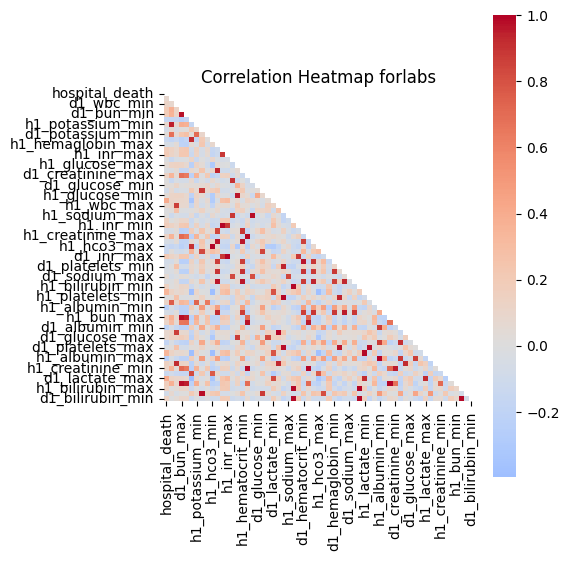

**********
vitals


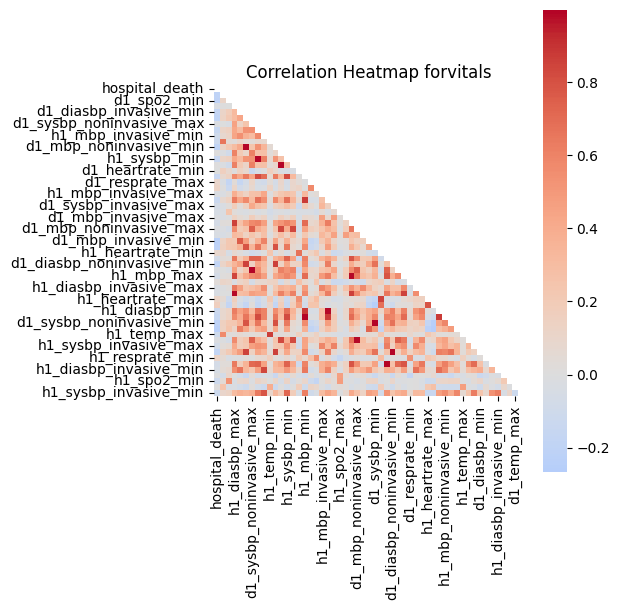

**********
demographic


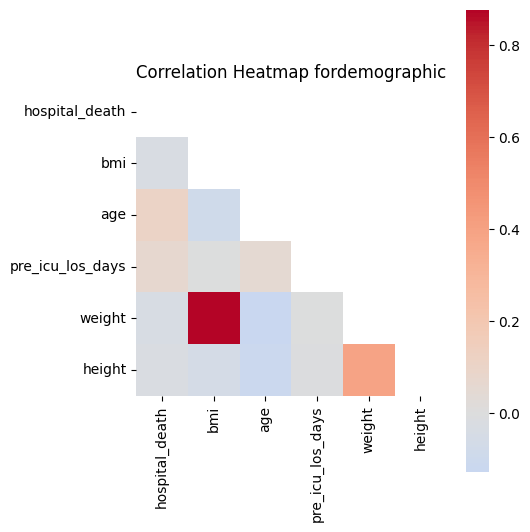

**********
labs blood gas


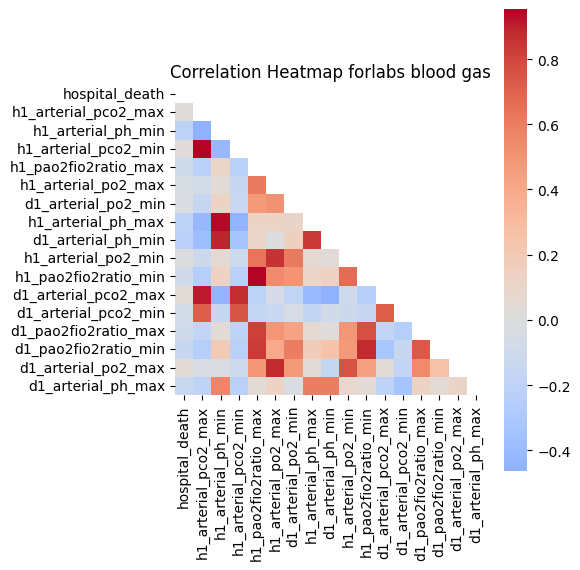

In [16]:
for sel_cat in exclude_APACHE_cat :
    if sel_cat in ['identifier' , 'GOSSIS example prediction']:
        continue
    else:
        print('*'*10)
        print(sel_cat)
        sel_vars = dict_df[dict_df['Category']==sel_cat]['Variable Name'].tolist()

        c_sel_vars = list(set(sel_vars) & set(numerical_vars))
        
        corr_mtx = source_df[ [target_var] + c_sel_vars ].corr()
        mask = np.triu(np.ones_like(corr_mtx, dtype=bool))
        plt.figure(figsize=(5, 6))
        sns.heatmap(corr_mtx, cmap="coolwarm", mask=mask,center=0, square=True, annot=False)
        plt.title("Correlation Heatmap for" + sel_cat)
        plt.show()
        #display(dict_df[dict_df['Category']==sel_cat])

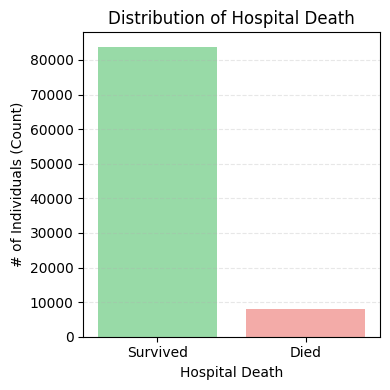

In [17]:
c = sns.color_palette("pastel")
target_var = 'hospital_death'
value_counts = source_df[target_var].value_counts()
category_order = [0, 1]  # If 0 is for 'Died' and 1 is for 'Survived'
category_labels = ['Survived', 'Died']
category_colors = [c[2], c[3]]

plt.figure(figsize=(4, 4))
sns.barplot(x=category_order, y=value_counts[category_order].values, palette=category_colors)

plt.title("Distribution of Hospital Death")
plt.ylabel('# of Individuals (Count)')
plt.xlabel("Hospital Death")
plt.xticks(ticks=category_order, labels=category_labels)  # Set custom labels on x-axis
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


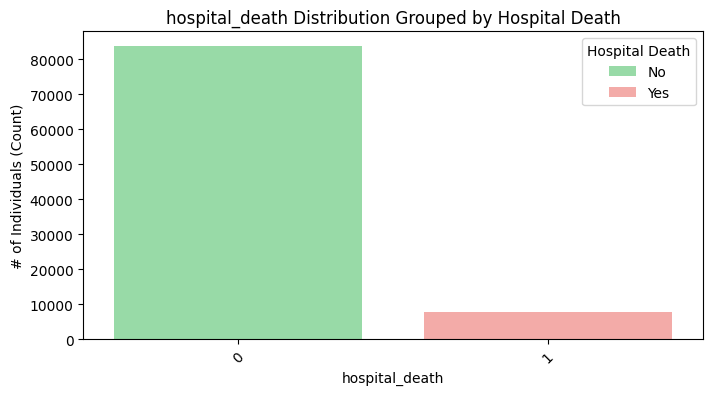

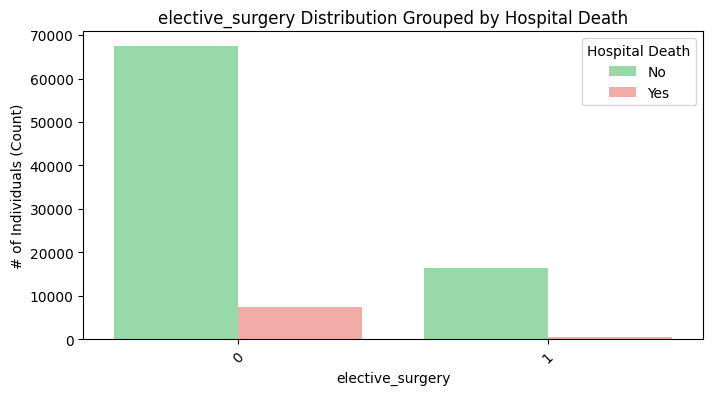

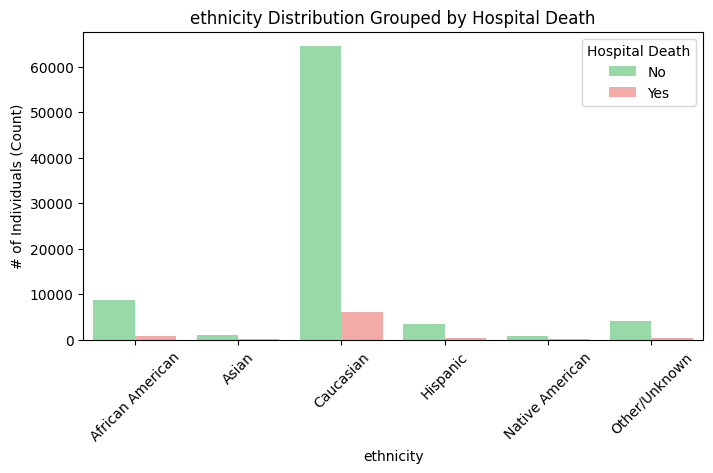

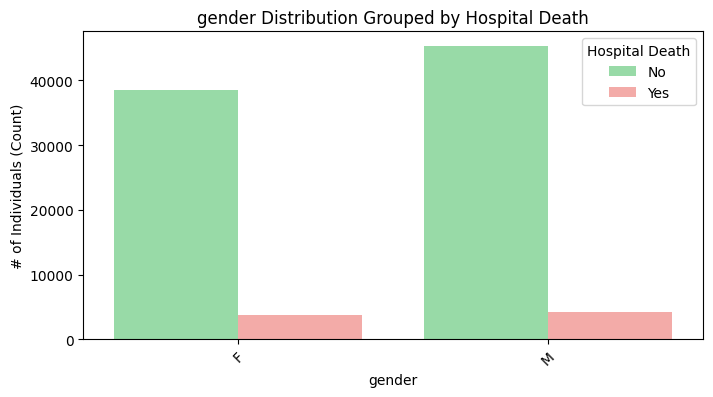

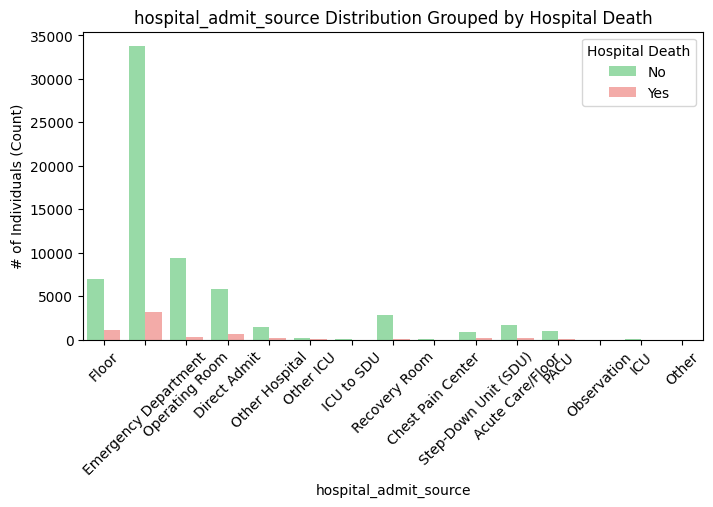

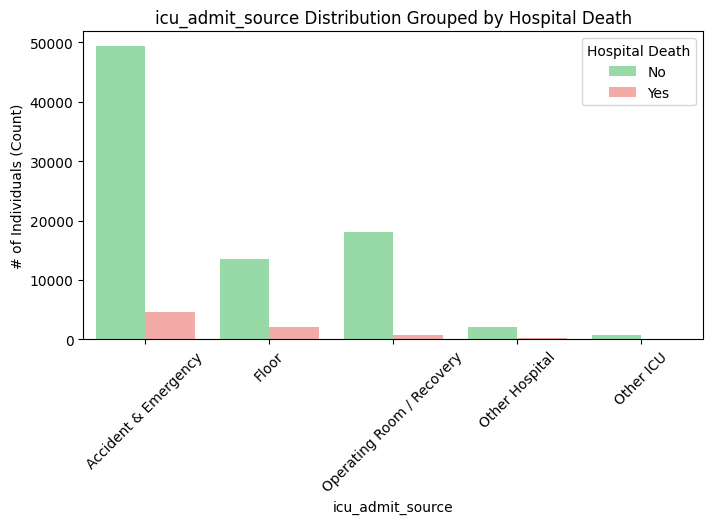

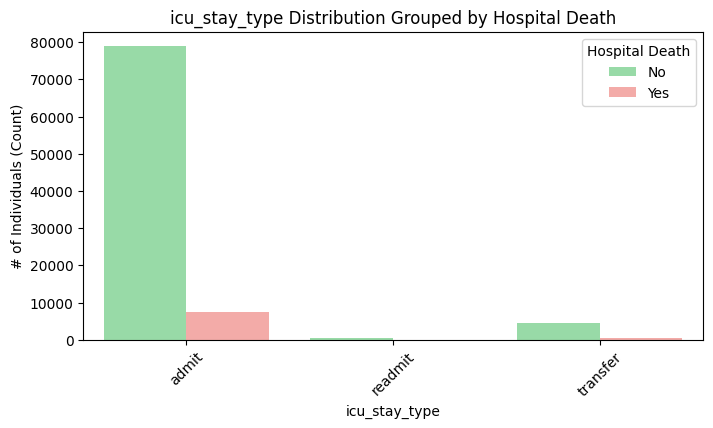

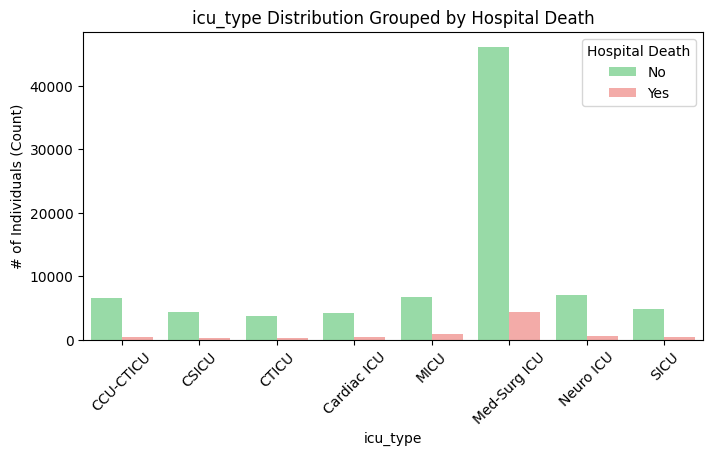

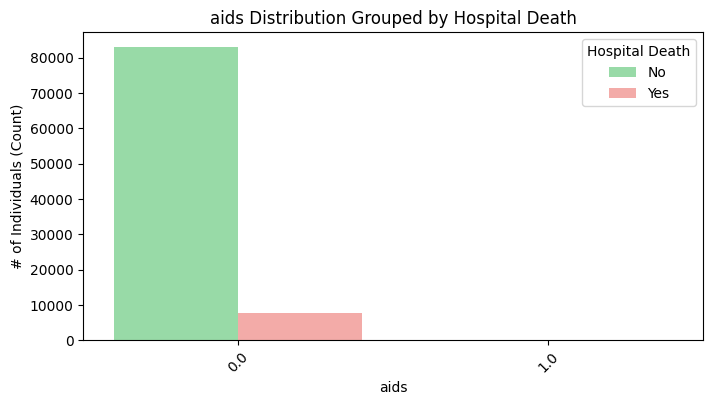

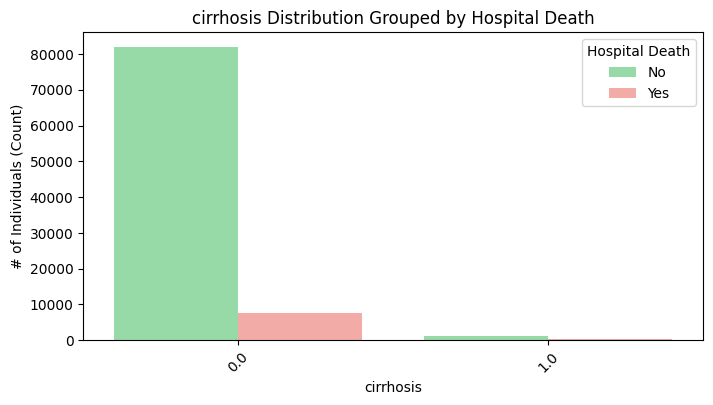

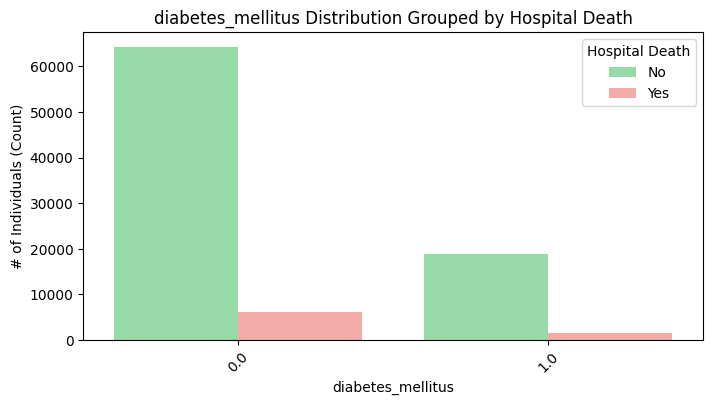

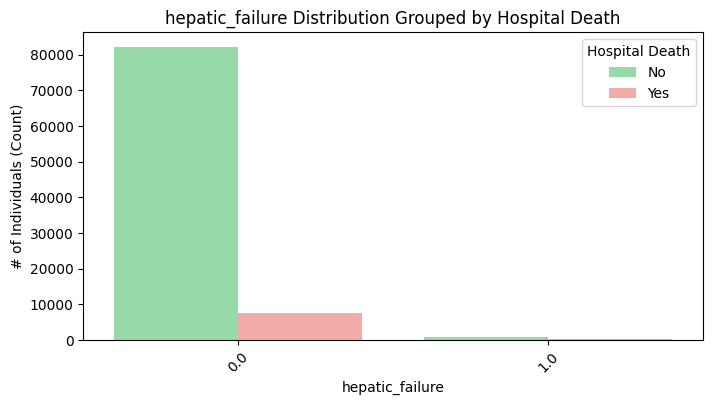

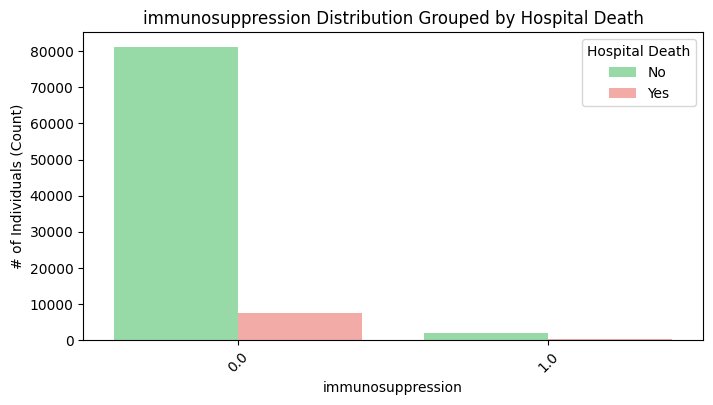

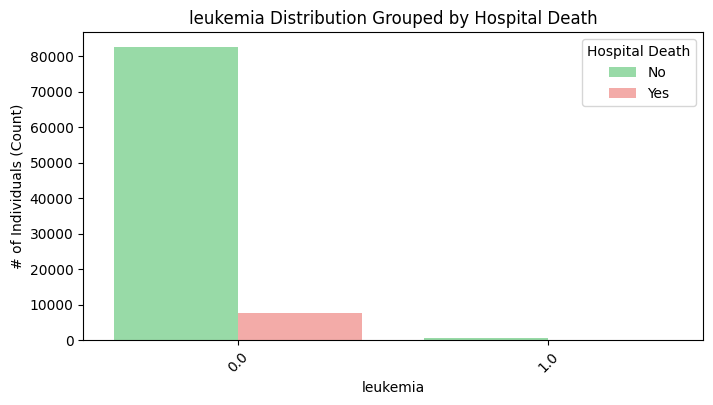

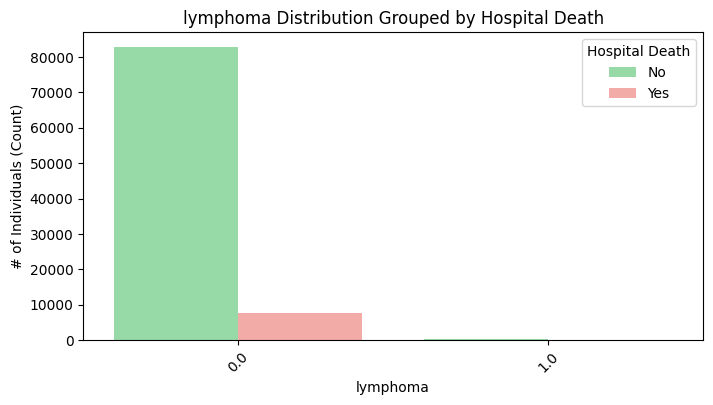

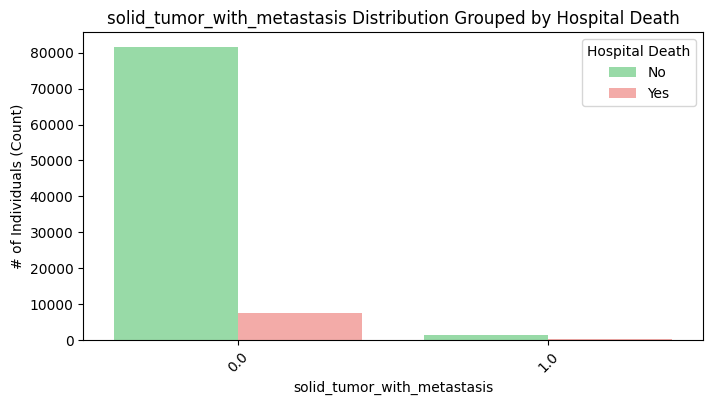

In [18]:
for feature in categorical_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=source_df, x=feature, hue=target_var, palette=category_colors)
    plt.title(f'{feature} Distribution Grouped by Hospital Death')
    plt.xlabel(feature)
    plt.ylabel('# of Individuals (Count)')
    plt.xticks(rotation=45)
    plt.legend(title='Hospital Death', labels=['No', 'Yes'])
    plt.show()

In [19]:
categorical_vars

['hospital_death',
 'elective_surgery',
 'ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [20]:
numerical_vars

['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'd1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_invasive_max',
 'd1_mbp_invasive_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_invasive_max',
 'd1_sysbp_invasive_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_invasive_max',
 'h1_diasbp_invasive_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_invasive_max',
 'h1_mbp_invasive_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_mbp_noninvasive_max',
 'h1_mbp_noninvasive_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_

In [21]:
exclude_APACHE_cat

['labs',
 'vitals',
 'demographic',
 'labs blood gas',
 'identifier',
 'GOSSIS example prediction']

**********
vitals


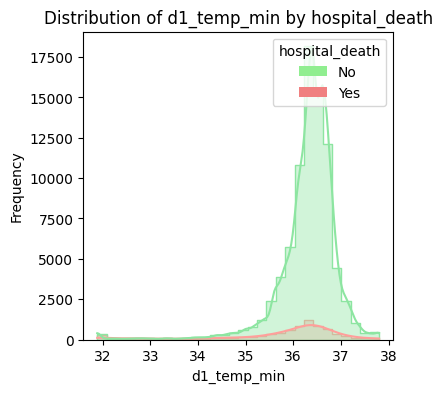

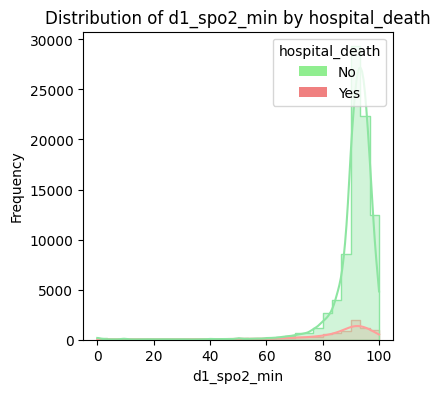

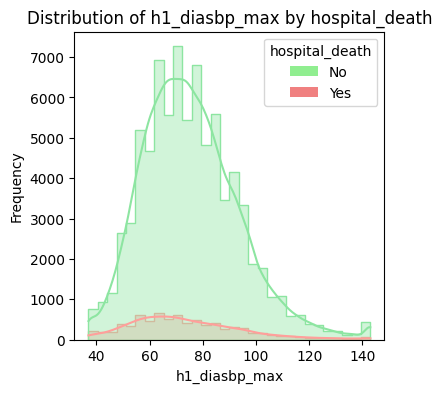

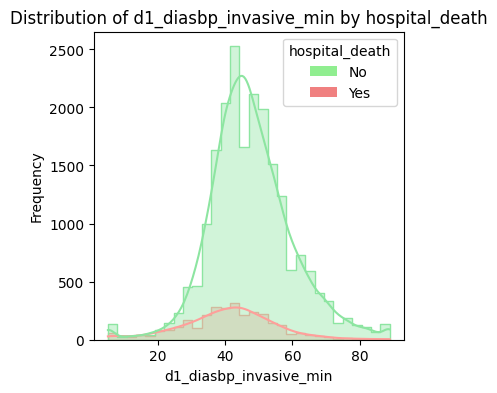

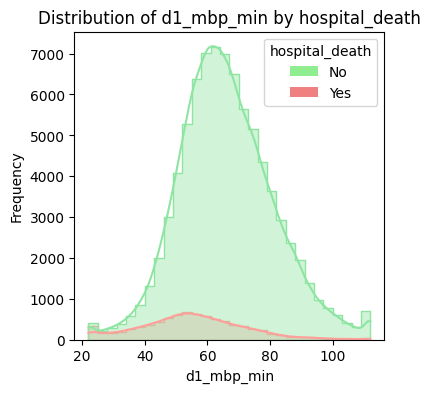

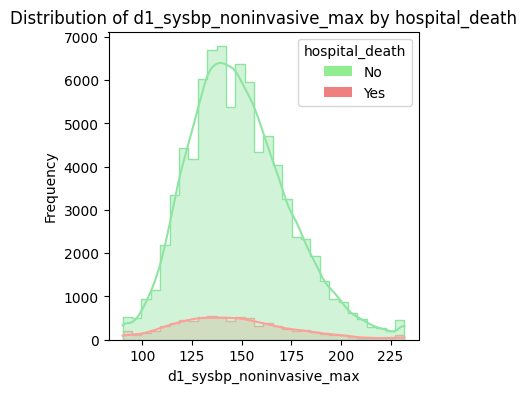

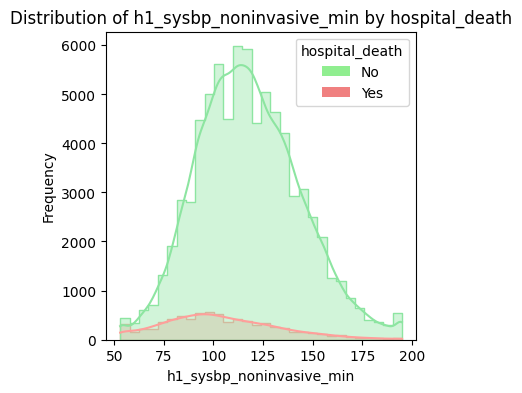

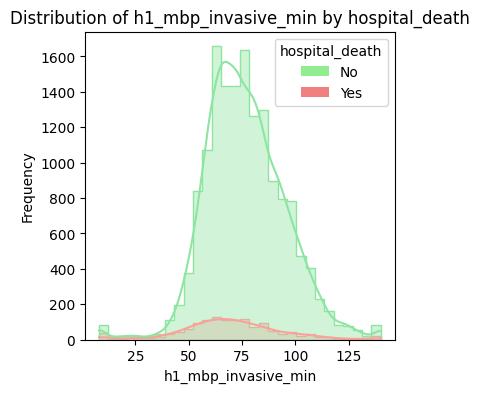

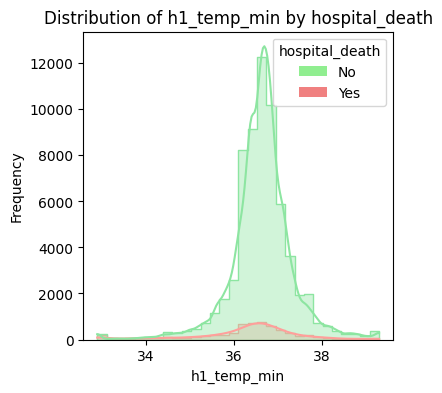

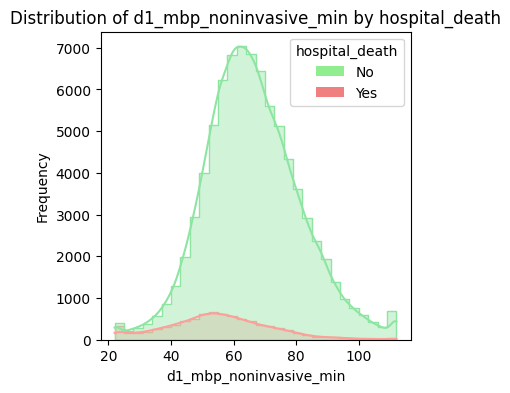

**********
demographic


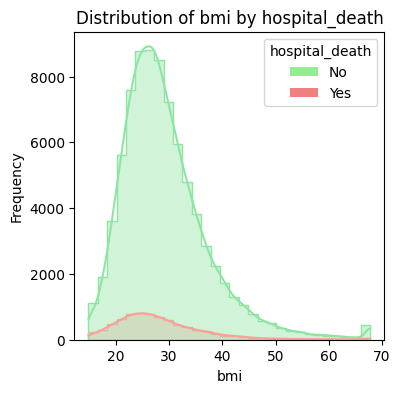

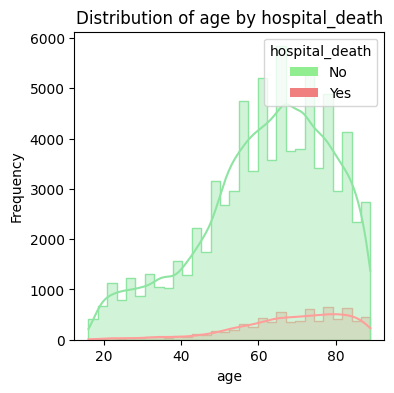

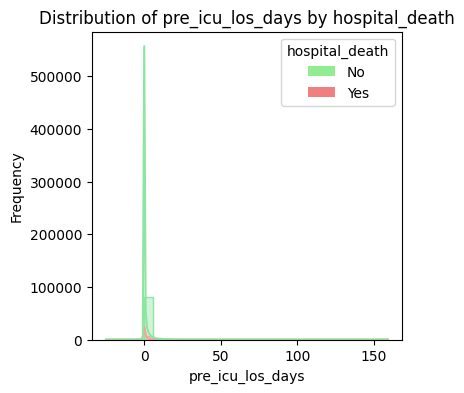

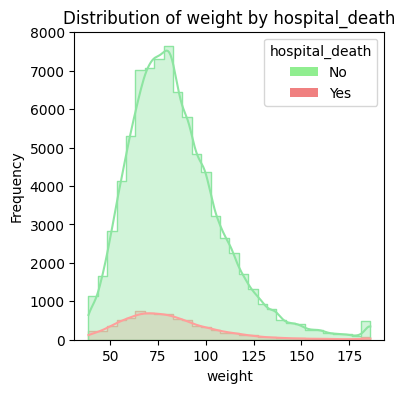

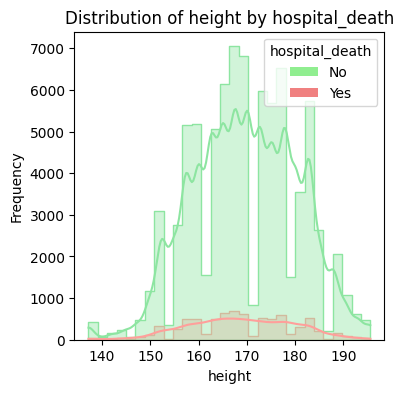

In [22]:
from matplotlib.patches import Patch

for sel_cat in exclude_APACHE_cat :
    if sel_cat in ['demographic', 'vitals']:
        print('*'*10)
        print(sel_cat)
        sel_vars = dict_df[dict_df['Category']==sel_cat]['Variable Name'].tolist()
        c_sel_vars = list(set(sel_vars) & set(numerical_vars))
        #print('total_columns', len(c_sel_vars))
        #assert(False)
        #for col in c_sel_vars:
        for col in c_sel_vars[:10]: # Limit the output
            plt.figure(figsize=(4, 4))
            sns.histplot(data=source_df, x=col, hue=target_var, kde=True, bins=30, palette=category_colors, element='step', alpha=0.4)
            plt.title(f'Distribution of {col} by hospital_death')
            plt.xlabel(col)
            plt.ylabel('Frequency')
        
            legend_elements = [ Patch(facecolor='lightgreen', label='No'), Patch(facecolor='lightcoral',label='Yes') ]
            plt.legend(handles=legend_elements, title='hospital_death', loc='upper right')
            plt.show()
        
    else:
        continue
        

# Missing Values

### Instead of dropping them, to investigate the missingness pattern
1. Either impute 999 to indicate "Not measure" (Data driven approach)
2. Impute with Median group by conditions <<<=== Need to investigagte further
3. Impute with Multiple Imputation (MICE)

In [23]:
df = source_df.copy()

#source_df = df.copy()

In [24]:
num_missing = [col for col in numerical_vars if source_df[col].isnull().sum() > 0]
missing_num_percent = (source_df[num_missing].isnull().sum() / len(source_df)) 
missing_num_percent = missing_num_percent.sort_values(ascending=False)
print(missing_num_percent)

h1_bilirubin_min    0.922650
h1_bilirubin_max    0.922650
h1_lactate_min      0.919924
h1_lactate_max      0.919924
h1_albumin_min      0.913982
                      ...   
d1_diasbp_max       0.001799
d1_sysbp_max        0.001734
d1_sysbp_min        0.001734
d1_heartrate_min    0.001581
d1_heartrate_max    0.001581
Length: 132, dtype: float64


In [25]:
cat_missing = [col for col in categorical_vars if source_df[col].isnull().sum() > 0]
missing_cat_percent = (source_df[cat_missing].isnull().sum() / len(source_df)) 
missing_cat_percent = missing_cat_percent.sort_values(ascending=False)
print(missing_cat_percent)

hospital_admit_source          0.233435
ethnicity                      0.015210
aids                           0.007796
cirrhosis                      0.007796
diabetes_mellitus              0.007796
hepatic_failure                0.007796
immunosuppression              0.007796
leukemia                       0.007796
lymphoma                       0.007796
solid_tumor_with_metastasis    0.007796
icu_admit_source               0.001221
gender                         0.000273
dtype: float64


In [26]:
missing_threshold = 0.6

cat_columns_to_drop = missing_cat_percent[missing_cat_percent > missing_threshold].index
num_columns_to_drop = missing_num_percent[missing_num_percent > missing_threshold].index

In [27]:
num_columns_to_drop

Index(['h1_bilirubin_min', 'h1_bilirubin_max', 'h1_lactate_min',
       'h1_lactate_max', 'h1_albumin_min', 'h1_albumin_max',
       'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_arterial_ph_min',
       'h1_arterial_ph_max', 'h1_hco3_max', 'h1_hco3_min',
       'h1_arterial_pco2_min', 'h1_arterial_pco2_max', 'h1_wbc_min',
       'h1_wbc_max', 'h1_arterial_po2_min', 'h1_arterial_po2_max',
       'h1_calcium_min', 'h1_calcium_max', 'h1_platelets_max',
       'h1_platelets_min', 'h1_bun_min', 'h1_bun_max', 'h1_creatinine_min',
       'h1_creatinine_max', 'h1_diasbp_invasive_min', 'h1_diasbp_invasive_max',
       'h1_sysbp_invasive_min', 'h1_sysbp_invasive_max', 'h1_mbp_invasive_max',
       'h1_mbp_invasive_min', 'h1_hematocrit_max', 'h1_hematocrit_min',
       'h1_hemaglobin_min', 'h1_hemaglobin_max', 'h1_sodium_max',
       'h1_sodium_min', 'h1_potassium_max', 'h1_potassium_min',
       'd1_lactate_max', 'd1_lactate_min', 'd1_diasbp_invasive_max',
       'd1_diasbp_invasive_min',

=> Imputation may introduce bias if data is not missing at random.

=> Some values may be missing because they weren’t measured due to clinical decisions (e.g., arterial blood gases not taken unless respiratory distress is suspected)


=>  As 'h1' for hourly assessment and 'd1' for daily assessment

=> Even if 70% is missed, retain the 'h' prefix variables 

We I will treat it as "not measured" and impute '999'

In [28]:
# missing_threshold = 0.6
num_columns_to_drop = missing_num_percent[missing_num_percent > missing_threshold]
h1_columns = num_columns_to_drop[num_columns_to_drop.index.str.startswith('h1')].index.tolist()
num_columns_to_drop = num_columns_to_drop[~num_columns_to_drop.index.str.startswith('h1')].index.tolist()
print("Columns to drop:", num_columns_to_drop)
print("Columns to impute:", h1_columns)

Columns to drop: ['d1_lactate_max', 'd1_lactate_min', 'd1_diasbp_invasive_max', 'd1_diasbp_invasive_min', 'd1_sysbp_invasive_min', 'd1_sysbp_invasive_max', 'd1_mbp_invasive_min', 'd1_mbp_invasive_max', 'd1_pao2fio2ratio_min', 'd1_pao2fio2ratio_max', 'd1_arterial_ph_max', 'd1_arterial_ph_min', 'd1_arterial_pco2_max', 'd1_arterial_pco2_min', 'd1_arterial_po2_max', 'd1_arterial_po2_min', 'd1_inr_min', 'd1_inr_max']
Columns to impute: ['h1_bilirubin_min', 'h1_bilirubin_max', 'h1_lactate_min', 'h1_lactate_max', 'h1_albumin_min', 'h1_albumin_max', 'h1_pao2fio2ratio_min', 'h1_pao2fio2ratio_max', 'h1_arterial_ph_min', 'h1_arterial_ph_max', 'h1_hco3_max', 'h1_hco3_min', 'h1_arterial_pco2_min', 'h1_arterial_pco2_max', 'h1_wbc_min', 'h1_wbc_max', 'h1_arterial_po2_min', 'h1_arterial_po2_max', 'h1_calcium_min', 'h1_calcium_max', 'h1_platelets_max', 'h1_platelets_min', 'h1_bun_min', 'h1_bun_max', 'h1_creatinine_min', 'h1_creatinine_max', 'h1_diasbp_invasive_min', 'h1_diasbp_invasive_max', 'h1_sysbp_

In [29]:
print("Before Dropping Category Missing Values ", source_df.shape[1])
source_df.drop(columns=cat_columns_to_drop, inplace=True)
print("AFter Dropping Category Missing Values",source_df.shape[1])

print("Before Dropping Numerical Missing Values", source_df.shape[1])
source_df.drop(columns=num_columns_to_drop, inplace=True)
print("Imputed columns")
source_df[h1_columns] = source_df[h1_columns].fillna(999)
print("AFter Dropping Numerical Missing Values", source_df.shape[1])

Before Dropping Category Missing Values  149
AFter Dropping Category Missing Values 149
Before Dropping Numerical Missing Values 149
Imputed columns
AFter Dropping Numerical Missing Values 131


###  Impute the rest of the missing values 

In [30]:
numerical_vars = source_df.select_dtypes(include=["number"]).columns.tolist()

num_missing_after = [col for col in numerical_vars if source_df[col].isnull().sum() > 0]
d1_h1_columns = [col for col in num_missing_after if col.startswith(('d1_', 'h1_'))]
demo_cols = [col for col in num_missing_after if col not in d1_h1_columns]
print("Columns starting with 'd1_' or 'h1_':", d1_h1_columns)
print("The rest of the variables ':", demo_cols)

# Impute  continuous numerical variables with median values
source_df[d1_h1_columns] = source_df[d1_h1_columns].fillna(999)
for col in demo_cols:
    source_df[col].fillna(source_df[col].median(), inplace=True)

Columns starting with 'd1_' or 'h1_': ['d1_diasbp_max', 'd1_diasbp_min', 'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min', 'd1_temp_max', 'd1_temp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min', 'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min', 'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_resprate_max', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min', 'h1_temp_max', 'h1_temp_min', 'd1_albumin_max', 'd1_albumin_min', 'd1_bilirubin_max', 'd1_bilirubin_min', 'd1_bun_max', 'd1_bun_min', 'd1_calcium_max', 'd1_calcium_min', 'd1_creatinine_max', 'd1_

In [31]:
num_missing = [col for col in numerical_vars if source_df[col].isnull().sum() > 0]
print(num_missing)

[]


### Drop features has correlation score > 70

In [32]:
eliminate_correlation = False
if eliminate_correlation:
    correlation_threshold = 0.7
    numerical_df = source_df[numerical_vars]
    corr_matrix = numerical_df.corr()
    high_corr_mask = (np.abs(corr_matrix) > correlation_threshold ) & ~np.eye(corr_matrix.shape[0], dtype=bool)
    features_to_drop = set()
    
    while high_corr_mask.values.any():
        counts = high_corr_mask.sum(axis=0)
        feature_to_drop = counts.idxmax()
        features_to_drop.add(feature_to_drop)
        high_corr_mask.loc[feature_to_drop, :] = False
        high_corr_mask.loc[:, feature_to_drop] = False
    print(features_to_drop)
    source_df.drop(columns=list(features_to_drop), inplace=True)

In [33]:
source_df.shape

(91713, 131)

### Handle missing values in Categorical_vars

In [34]:
missing_cat_percent

hospital_admit_source          0.233435
ethnicity                      0.015210
aids                           0.007796
cirrhosis                      0.007796
diabetes_mellitus              0.007796
hepatic_failure                0.007796
immunosuppression              0.007796
leukemia                       0.007796
lymphoma                       0.007796
solid_tumor_with_metastasis    0.007796
icu_admit_source               0.001221
gender                         0.000273
dtype: float64

In [35]:

cat_missing

['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [36]:
source_df['hospital_admit_source'] = source_df['hospital_admit_source'].fillna("Unknown")
print("Before Dropping Categorical Missing Values", source_df.shape)
source_df.dropna(subset=[col for col in cat_missing if col != 'hospital_admit_source'], inplace=True)
print("After Dropping Categorical Missing Values", source_df.shape)

Before Dropping Categorical Missing Values (91713, 131)
After Dropping Categorical Missing Values (89488, 131)


In [37]:
for cat in categorical_vars:
    print(source_df[cat] .value_counts())

hospital_death
0    81779
1     7709
Name: count, dtype: int64
elective_surgery
0    72945
1    16543
Name: count, dtype: int64
ethnicity
Caucasian           70049
African American     9447
Other/Unknown        4329
Hispanic             3757
Asian                1125
Native American       781
Name: count, dtype: int64
gender
M    48242
F    41246
Name: count, dtype: int64
hospital_admit_source
Emergency Department    35942
Unknown                 21071
Operating Room           9599
Floor                    7861
Direct Admit             6208
Recovery Room            2863
Acute Care/Floor         1787
Other Hospital           1598
Step-Down Unit (SDU)     1106
PACU                      999
Other ICU                 230
Chest Pain Center         129
ICU to SDU                 44
ICU                        35
Observation                10
Other                       6
Name: count, dtype: int64
icu_admit_source
Accident & Emergency         52912
Operating Room / Recovery    18350
Floor     

In [38]:
#sns.pairplot(source_df, hue=target_var, palette=category_colors)
#plt.show()

In [39]:
source_df.head(2)

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_stay_type,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,0,68.0,22.73,0,Caucasian,M,180.3,Floor,Floor,admit,...,999.0,999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,77.0,27.42,0,Caucasian,F,160.0,Floor,Floor,admit,...,51.0,51.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [40]:
source_df.to_csv('clean_df.csv', header=False)

# Data Preprocessing : Inspect the levels of categorical variables


In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def preprocess_data(source_df, binary_cols, dummy_columns):

    t_df = source_df.copy()

    if "hospital_admit_source" in t_df.columns:
        t_df["hospital_admit_source"] = t_df["hospital_admit_source"].fillna("Unknown")
    categorical_missing_cols = [col for col in dummy_columns if col in t_df.columns and t_df[col].isnull().sum() > 0]
    t_df.dropna(subset=categorical_missing_cols, inplace=True)

    h1_d1_cols = [col for col in t_df.columns if col.startswith('h1') or col.startswith('d1')]
    continuous_columns = [col for col in t_df.select_dtypes(include=["number"]).columns 
                          if col not in h1_d1_cols + ["hospital_death"]]
    t_df[h1_d1_cols] = t_df[h1_d1_cols].fillna(999)

    for col in continuous_columns:
        t_df[col].fillna(t_df[col].median(), inplace=True)
    if "gender" in t_df.columns:
        t_df["gender"] = t_df["gender"].map({"M": 1, "F": 0}).astype("category")

    for col in binary_cols:
        if col in t_df.columns:
            t_df[col] = t_df[col].astype("category")

    if "hospital_admit_source" in t_df.columns:
        rare_categories = t_df["hospital_admit_source"].value_counts()[t_df["hospital_admit_source"].value_counts() < 500].index
        t_df["hospital_admit_source"] = t_df["hospital_admit_source"].replace(rare_categories, "Other/Unknown")

    t_df = pd.get_dummies(t_df, columns=dummy_columns, drop_first=True, dtype=bool)
    boolean_columns = t_df.select_dtypes(include=['bool']).columns
    t_df[boolean_columns] = t_df[boolean_columns].astype(int)
    
    t_df["hospital_death"] = t_df["hospital_death"].astype(int)

    return t_df

In [42]:
binary_cols = ['elective_surgery', 'aids', 'cirrhosis', 'diabetes_mellitus', 
               'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 
               'solid_tumor_with_metastasis']

dummy_columns = ['ethnicity', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']

processed_df = preprocess_data(source_df, binary_cols, dummy_columns)
print(processed_df.shape)

(89488, 154)


In [43]:
for i in range(0, len(processed_df.columns), 20):
    display(processed_df.iloc[:, i:i+20].head(1))

,hospital_death,age,bmi,elective_surgery,gender,height,pre_icu_los_days,weight,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min
0,0,68.0,22.73,0,1,180.3,0.541667,73.9,68.0,37.0,68.0,37.0,119.0,72.0,89.0,46.0,89.0,46.0,34.0,10.0


,d1_spo2_max,d1_spo2_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min
0,100.0,74.0,131.0,73.0,131.0,73.0,39.9,37.2,999.0,999.0,68.0,63.0,68.0,63.0,119.0,108.0,999.0,999.0,86.0,85.0


,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min
0,86.0,85.0,26.0,18.0,100.0,74.0,999.0,999.0,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0


,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min
0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1


,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min
0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0


,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis
0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0.0,0.0


,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,hospital_admit_source_Direct Admit,hospital_admit_source_Emergency Department,hospital_admit_source_Floor,hospital_admit_source_Operating Room,hospital_admit_source_Other Hospital,hospital_admit_source_Other/Unknown,hospital_admit_source_PACU,hospital_admit_source_Recovery Room,hospital_admit_source_Step-Down Unit (SDU)
0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


,hospital_admit_source_Unknown,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU
0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


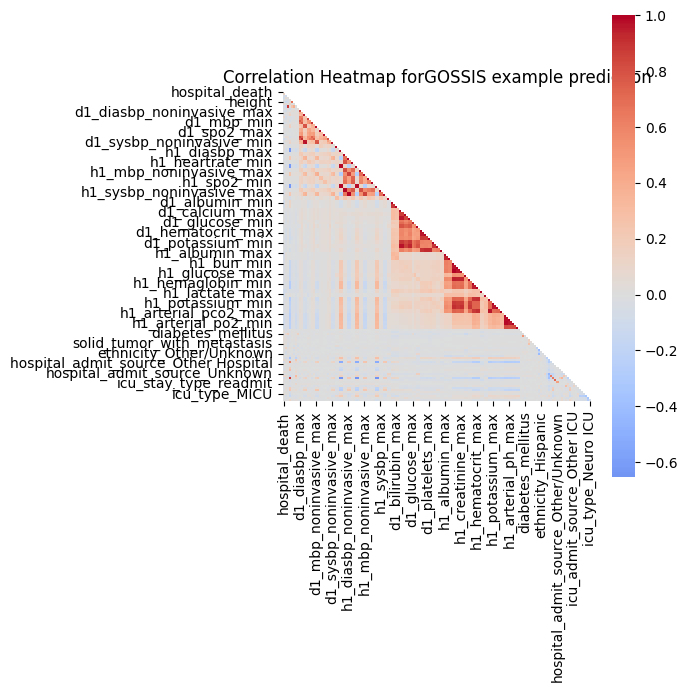

In [44]:
corr_mtx = processed_df.corr()
mask = np.triu(np.ones_like(corr_mtx, dtype=bool))
plt.figure(figsize=(5, 6))
sns.heatmap(corr_mtx, cmap="coolwarm", mask=mask,center=0, square=True, annot=False)
plt.title("Correlation Heatmap for" + sel_cat)
plt.show()

# Model Building

# # RQ 1:

To determine whether deep learning models can effectively predict ICU mortality using these early indicators and Identify which features are most influential in the prediction.

In [45]:
processed_df = preprocess_data(source_df, binary_cols, dummy_columns)

classes = processed_df['hospital_death'].unique()
y = processed_df.pop('hospital_death')
X = processed_df.copy()

display(X.sample(2))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("y_train value_counts", y_train.value_counts())
print("y_test value_counts", y_test.value_counts())
X_train.shape, X_test.shape, y_train.shape, y_test.shape


,age,bmi,elective_surgery,gender,height,pre_icu_los_days,weight,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,...,icu_admit_source_Other ICU,icu_stay_type_readmit,icu_stay_type_transfer,icu_type_CSICU,icu_type_CTICU,icu_type_Cardiac ICU,icu_type_MICU,icu_type_Med-Surg ICU,icu_type_Neuro ICU,icu_type_SICU
5701,82.0,30.429688,0,0,160.0,0.003472,77.9,80.0,45.0,80.0,...,0,0,0,0,0,0,0,0,0,0
65312,80.0,33.717105,0,0,152.0,3.734722,77.9,111.0,34.0,111.0,...,0,0,0,0,0,0,0,0,0,0


y_train value_counts hospital_death
0    65423
1     6167
Name: count, dtype: int64
y_test value_counts hospital_death
0    16356
1     1542
Name: count, dtype: int64


((71590, 153), (17898, 153), (71590,), (17898,))

## LogisticRegression

In [46]:
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, lr_y_pred, labels=classes ) )
print(classification_report(y_test, lr_y_pred, labels=classes ))

[[12311  4045]
 [  434  1108]]
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     16356
           1       0.22      0.72      0.33      1542

    accuracy                           0.75     17898
   macro avg       0.59      0.74      0.59     17898
weighted avg       0.90      0.75      0.80     17898



# Oversampling with SMOTE

In [47]:
from imblearn.over_sampling import SMOTE  

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Print class distributions
print("y_train value_counts", y_train_resampled.value_counts())
print("y_test value_counts", y_test.value_counts())

lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train_scaled, y_train_resampled)
lr_y_pred = lr.predict(X_test_scaled)

print(confusion_matrix(y_test, lr_y_pred, labels=classes ) )
print(classification_report(y_test, lr_y_pred, labels=classes ))

y_train value_counts hospital_death
0    65423
1    65423
Name: count, dtype: int64
y_test value_counts hospital_death
0    16356
1     1542
Name: count, dtype: int64
[[12300  4056]
 [  458  1084]]
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     16356
           1       0.21      0.70      0.32      1542

    accuracy                           0.75     17898
   macro avg       0.59      0.73      0.58     17898
weighted avg       0.90      0.75      0.80     17898



## Fine-tunning Paramerters - LogisticRegression

from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
}

log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

grid_search = GridSearchCV( estimator=log_reg,param_grid=params, scoring='f1', cv=5, verbose=1, n_jobs=-1 )
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params, best_score)

y_pred = grid_search.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred, labels=classes ))
print(confusion_matrix(y_test, y_pred, labels=classes ) )

In [89]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE  

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

oversampled = True
binary_cols = ['elective_surgery', 'aids', 'cirrhosis', 'diabetes_mellitus', 
               'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 
               'solid_tumor_with_metastasis']
dummy_columns = ['ethnicity', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']

processed_df = preprocess_data(source_df, binary_cols, dummy_columns)

y = processed_df.pop('hospital_death')
X = processed_df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("NaN values before SMOTE:", X_train.isnull().sum().sum())  # Check total NaNs



smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

unique_counts = (X_train_resampled.nunique() == 1).sum() 
if unique_counts > 0:
    print(f"Warning: {unique_counts} columns have only one unique value. Dropping them.")
    X_train_resampled = X_train_resampled.loc[:, X_train_resampled.nunique() > 1]  


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = np.nan_to_num(X_train_scaled)  # Replace NaNs with 0
X_test_scaled = np.nan_to_num(X_test_scaled)  # Replace NaNs with 0
print("y_train value_counts", y_train_resampled.value_counts())
print("y_test value_counts", y_test.value_counts())

 
scaler1 = StandardScaler()
X_train_scaled1 = scaler1.fit_transform(X_train)
X_test_scaled1 = scaler1.transform(X_test)

X_train_scaled1 = np.nan_to_num(X_train_scaled1)  # Replace NaNs with 0
X_test_scaled1 = np.nan_to_num(X_test_scaled1)  # Replace NaNs with 0
    

if np.isnan(X_train_scaled).any() or np.isinf(X_train_scaled).any():
    print(" NaN or Inf still exists!")
else:
    print("No NaN or Inf values found")



NaN values before SMOTE: 0
y_train value_counts hospital_death
0    65423
1    65423
Name: count, dtype: int64
y_test value_counts hospital_death
0    16356
1     1542
Name: count, dtype: int64
No NaN or Inf values found


In [97]:
# Calculate scale_pos_weight for imbalance
#num_neg = (y_train == 0).sum()  # Survived
#num_pos = (y_train == 1).sum()  # Death
#scale_pos_weight = num_neg / num_pos
#print(f"scale_pos_weight: {scale_pos_weight:.2f}")


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier( objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Naive Bayes": GaussianNB()
}

results, results1 = {}, {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[name] = {
        "Accuracy": acc,
        "Precision (Survived 0)": report["0"]["precision"],
        "Recall (Survived 0)": report["0"]["recall"],
        "F1-score (Survived 0)": report["0"]["f1-score"],
        "Precision (Death 1)": report["1"]["precision"],
        "Recall (Death 1)": report["1"]["recall"],
        "F1-score (Death 1)": report["1"]["f1-score"],
        "Confusion Matrix": conf_matrix.tolist()
    }

In [98]:
results

{'Logistic Regression': {'Accuracy': 0.8662979103810482,
  'Precision (Survived 0)': 0.9329612403100775,
  'Recall (Survived 0)': 0.9197847884568354,
  'F1-score (Survived 0)': 0.9263261599088698,
  'Precision (Death 1)': 0.26001128031584886,
  'Recall (Death 1)': 0.29896238651102464,
  'F1-score (Death 1)': 0.2781297134238311,
  'Confusion Matrix': [[15044, 1312], [1081, 461]]},
 'Random Forest': {'Accuracy': 0.9118895966029724,
  'Precision (Survived 0)': 0.9358815548870406,
  'Recall (Survived 0)': 0.9700415749572022,
  'F1-score (Survived 0)': 0.9526554384700832,
  'Precision (Death 1)': 0.48148148148148145,
  'Recall (Death 1)': 0.29507133592736706,
  'F1-score (Death 1)': 0.365902694008846,
  'Confusion Matrix': [[15866, 490], [1087, 455]]},
 'XGBoost': {'Accuracy': 0.9201028047826573,
  'Precision (Survived 0)': 0.9371485473289597,
  'Recall (Survived 0)': 0.9781731474688188,
  'F1-score (Survived 0)': 0.9572214909656576,
  'Precision (Death 1)': 0.5677966101694916,
  'Recall (D

In [99]:
for name, model in models.items():
    model.fit(X_train_scaled1, y_train)
    y_pred = model.predict(X_test_scaled1)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results1[name] = {
        "Accuracy": acc,
        "Precision (Survived 0)": report["0"]["precision"],
        "Recall (Survived 0)": report["0"]["recall"],
        "F1-score (Survived 0)": report["0"]["f1-score"],
        "Precision (Death 1)": report["1"]["precision"],
        "Recall (Death 1)": report["1"]["recall"],
        "F1-score (Death 1)": report["1"]["f1-score"],
        "Confusion Matrix": conf_matrix.tolist()
    }

In [100]:
results1

{'Logistic Regression': {'Accuracy': 0.7497485752598055,
  'Precision (Survived 0)': 0.965947430364849,
  'Recall (Survived 0)': 0.7526901442895574,
  'F1-score (Survived 0)': 0.8460877633071029,
  'Precision (Death 1)': 0.21502037647972055,
  'Recall (Death 1)': 0.7185473411154345,
  'F1-score (Death 1)': 0.3309932785660941,
  'Confusion Matrix': [[12311, 4045], [434, 1108]]},
 'Random Forest': {'Accuracy': 0.9174768130517377,
  'Precision (Survived 0)': 0.918914353285658,
  'Recall (Survived 0)': 0.997737833211054,
  'F1-score (Survived 0)': 0.9567052616151253,
  'Precision (Death 1)': 0.7338129496402878,
  'Recall (Death 1)': 0.06614785992217899,
  'F1-score (Death 1)': 0.12135633551457466,
  'Confusion Matrix': [[16319, 37], [1440, 102]]},
 'XGBoost': {'Accuracy': 0.9216672253883116,
  'Precision (Survived 0)': 0.935621067350268,
  'Recall (Survived 0)': 0.9818415260454879,
  'F1-score (Survived 0)': 0.9581742243436754,
  'Precision (Death 1)': 0.5953678474114441,
  'Recall (Death 

In [101]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from icumodel import ICUModel, ICUModel_v1, ICUModel_v2, Wide, Deep

def train_deep_learning_model(dataparcel, icu_model, input_dim, epochs=10, batch_size=32, learning_rate=0.0001, oversampled=True):

    X_train_scaled, y_train_resampled, X_test_scaled, y_test = dataparcel

    X_train_scaled = np.array(X_train_scaled, dtype=np.float32)
    X_test_scaled = np.array(X_test_scaled, dtype=np.float32)
    y_train_resampled = np.array(y_train_resampled, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)

    # check NaN or infinite values
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)

    # torch tensors
    X_train_tensor = torch.tensor(X_train_scaled)
    y_train_tensor = torch.tensor(y_train_resampled).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_scaled)
    y_test_tensor = torch.tensor(y_test).unsqueeze(1)

    # datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    model = icu_model(input_dim)

    criterion = nn.BCEWithLogitsLoss()  #binary classification
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            if torch.isnan(loss).any():
                print("ERROR:: NaN loss,  stopping training")
                return results, report, model

            loss.backward()  # backpropagation
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Evaluation on test data
        model.eval()
        preds = []
        actuals = []
        with torch.no_grad():  # disable gradient computation for test data
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
                outputs = model(X_batch)
                probabilities = torch.sigmoid(outputs)
                predictions = (probabilities > 0.5).int()
                preds.extend(predictions.cpu().numpy())
                actuals.extend(y_batch.cpu().numpy())

        accuracy = accuracy_score(actuals, preds)
        report_ = classification_report(actuals, preds, output_dict=True)
        conf_matrix = confusion_matrix(actuals, preds)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

    report = {str(int(float(k))) if k.replace('.', '', 1).isdigit() else k: v for k, v in report_.items()}

    model_name = icu_model.__name__
    if oversampled: 
      results[model_name] = {
        "Accuracy": accuracy,
        "Precision (Survived 0)": report["0"]["precision"],
        "Recall (Survived 0)": report["0"]["recall"],
        "F1-score (Survived 0)": report["0"]["f1-score"],
        "Precision (Death 1)": report["1"]["precision"],
        "Recall (Death 1)": report["1"]["recall"],
        "F1-score (Death 1)": report["1"]["f1-score"],
        "Confusion Matrix": conf_matrix.tolist()
    }
      return results, report_ , model
    else:
      results1[model_name] = {
        "Accuracy": accuracy,
        "Precision (Survived 0)": report["0"]["precision"],
        "Recall (Survived 0)": report["0"]["recall"],
        "F1-score (Survived 0)": report["0"]["f1-score"],
        "Precision (Death 1)": report["1"]["precision"],
        "Recall (Death 1)": report["1"]["recall"],
        "F1-score (Death 1)": report["1"]["f1-score"],
        "Confusion Matrix": conf_matrix.tolist()
     }
      return results1, report_ , model

### Using Oversampling data

In [102]:
dataparcel = (X_train_scaled, y_train_resampled, X_test_scaled, y_test)

In [103]:
import torch, os 
print(torch.backends.mps.is_available()) 
print(torch.backends.mps.is_built()) 
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch.mps
torch.mps.empty_cache()
print(torch.backends.mps.is_available()) 
print(torch.backends.mps.is_built()) 

True
True
True
True


In [104]:
results, ICUModel_report, _ = train_deep_learning_model(dataparcel, ICUModel, input_dim=X_train_scaled.shape[1], epochs=20, batch_size=8)
print(results["ICUModel"])  

Epoch 1/20 - Loss: 0.4066, Accuracy: 0.8845
Epoch 2/20 - Loss: 0.3462, Accuracy: 0.8783
Epoch 3/20 - Loss: 0.3370, Accuracy: 0.8819
Epoch 4/20 - Loss: 0.3318, Accuracy: 0.8546
Epoch 5/20 - Loss: 0.3263, Accuracy: 0.8922
Epoch 6/20 - Loss: 0.3241, Accuracy: 0.8794
Epoch 7/20 - Loss: 0.3213, Accuracy: 0.8603
Epoch 8/20 - Loss: 0.3179, Accuracy: 0.8743
Epoch 9/20 - Loss: 0.3124, Accuracy: 0.8637
Epoch 10/20 - Loss: 0.3155, Accuracy: 0.8862
Epoch 11/20 - Loss: 0.3105, Accuracy: 0.8887
Epoch 12/20 - Loss: 0.3108, Accuracy: 0.8677
Epoch 13/20 - Loss: 0.3063, Accuracy: 0.8876
Epoch 14/20 - Loss: 0.3086, Accuracy: 0.8879
Epoch 15/20 - Loss: 0.3035, Accuracy: 0.8829
Epoch 16/20 - Loss: 0.3045, Accuracy: 0.8905
Epoch 17/20 - Loss: 0.3020, Accuracy: 0.8929
Epoch 18/20 - Loss: 0.3030, Accuracy: 0.8713
Epoch 19/20 - Loss: 0.3019, Accuracy: 0.8797
Epoch 20/20 - Loss: 0.3020, Accuracy: 0.8704
{'Accuracy': 0.8703765783886468, 'Precision (Survived 0)': 0.9306049822064056, 'Recall (Survived 0)': 0.92730

In [105]:
results, ICUModel_v1_report, _ = train_deep_learning_model(dataparcel, ICUModel_v1, input_dim=X_train_scaled.shape[1], epochs=20, batch_size=8)
print(results["ICUModel_v1"])  

Epoch 1/20 - Loss: 0.3925, Accuracy: 0.8661
Epoch 2/20 - Loss: 0.3383, Accuracy: 0.8751
Epoch 3/20 - Loss: 0.3305, Accuracy: 0.8759
Epoch 4/20 - Loss: 0.3220, Accuracy: 0.8637
Epoch 5/20 - Loss: 0.3146, Accuracy: 0.8376
Epoch 6/20 - Loss: 0.3092, Accuracy: 0.8410
Epoch 7/20 - Loss: 0.3035, Accuracy: 0.8307
Epoch 8/20 - Loss: 0.2989, Accuracy: 0.8347
Epoch 9/20 - Loss: 0.2957, Accuracy: 0.8504
Epoch 10/20 - Loss: 0.2897, Accuracy: 0.8516
Epoch 11/20 - Loss: 0.2853, Accuracy: 0.8547
Epoch 12/20 - Loss: 0.2828, Accuracy: 0.8810
Epoch 13/20 - Loss: 0.2835, Accuracy: 0.8721
Epoch 14/20 - Loss: 0.2805, Accuracy: 0.8753
Epoch 15/20 - Loss: 0.2799, Accuracy: 0.8753
Epoch 16/20 - Loss: 0.2795, Accuracy: 0.8807
Epoch 17/20 - Loss: 0.2762, Accuracy: 0.8900
Epoch 18/20 - Loss: 0.2788, Accuracy: 0.8966
Epoch 19/20 - Loss: 0.2780, Accuracy: 0.8912
Epoch 20/20 - Loss: 0.2756, Accuracy: 0.8855
{'Accuracy': 0.8854620628003129, 'Precision (Survived 0)': 0.9281695199329583, 'Recall (Survived 0)': 0.94803

In [106]:
results, ICUModel_v2_report, _ = train_deep_learning_model(dataparcel, ICUModel_v2, input_dim=X_train_scaled.shape[1], epochs=20, batch_size=8)
print(results["ICUModel_v2"])  

Epoch 1/20 - Loss: 0.3950, Accuracy: 0.8484
Epoch 2/20 - Loss: 0.3412, Accuracy: 0.8769
Epoch 3/20 - Loss: 0.3326, Accuracy: 0.8760
Epoch 4/20 - Loss: 0.3232, Accuracy: 0.8871
Epoch 5/20 - Loss: 0.3186, Accuracy: 0.8646
Epoch 6/20 - Loss: 0.3117, Accuracy: 0.8552
Epoch 7/20 - Loss: 0.3057, Accuracy: 0.8533
Epoch 8/20 - Loss: 0.2993, Accuracy: 0.8708
Epoch 9/20 - Loss: 0.2984, Accuracy: 0.8258
Epoch 10/20 - Loss: 0.2951, Accuracy: 0.8685
Epoch 11/20 - Loss: 0.2915, Accuracy: 0.8585
Epoch 12/20 - Loss: 0.2880, Accuracy: 0.8663
Epoch 13/20 - Loss: 0.2846, Accuracy: 0.8609
Epoch 14/20 - Loss: 0.2837, Accuracy: 0.8400
Epoch 15/20 - Loss: 0.2832, Accuracy: 0.8830
Epoch 16/20 - Loss: 0.2782, Accuracy: 0.8707
Epoch 17/20 - Loss: 0.2805, Accuracy: 0.8870
Epoch 18/20 - Loss: 0.2777, Accuracy: 0.8886
Epoch 19/20 - Loss: 0.2770, Accuracy: 0.8662
Epoch 20/20 - Loss: 0.2760, Accuracy: 0.8889
{'Accuracy': 0.8888702648340596, 'Precision (Survived 0)': 0.9268017348939457, 'Recall (Survived 0)': 0.95371

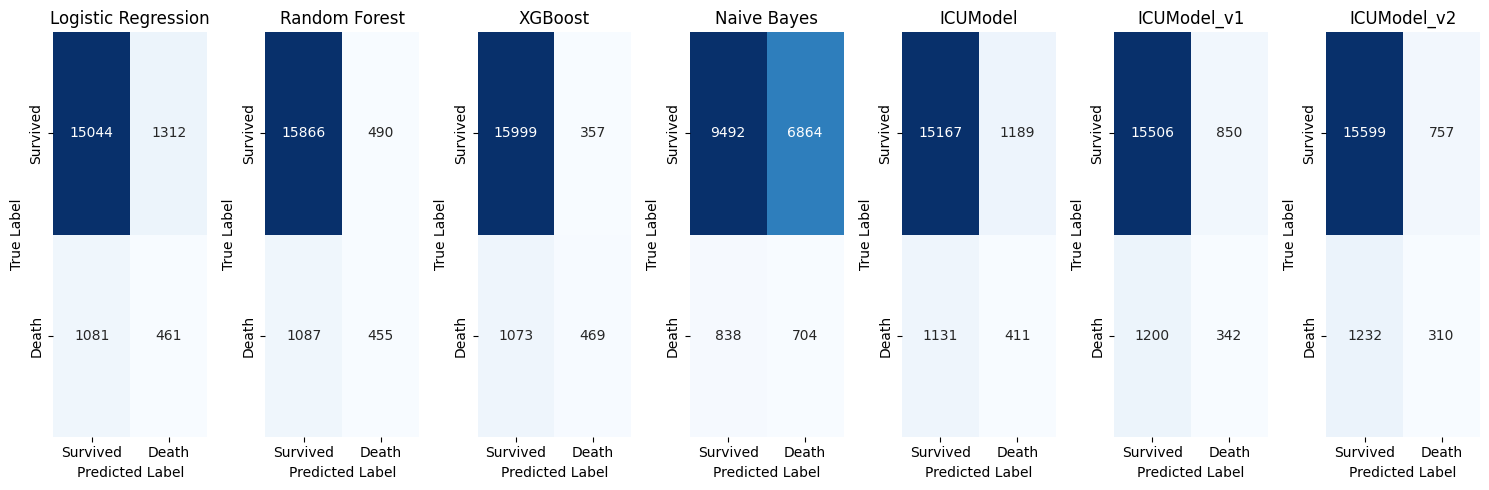

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(1, len(results), figsize=(15, 5))

for i, (model, data) in enumerate(results.items()):
    conf_matrix = np.array(data["Confusion Matrix"])
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(model)
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")
    axes[i].set_xticklabels(["Survived", "Death"])
    axes[i].set_yticklabels(["Survived", "Death"])

plt.tight_layout()
plt.show()

In [108]:
print_classification_report(results)


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.93       0.92       0.93      16356
   Death (1)      0.26       0.30       0.28       1542

    accuracy                           0.87      17898
   macro avg      0.60       0.61       0.60      17898
weighted avg      0.87       0.87       0.87      17898

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.94       0.97       0.95      16356
   Death (1)      0.48       0.30       0.37       1542

    accuracy                           0.91      17898
   macro avg      0.71       0.63       0.66      17898
weighted avg      0.90       0.91       0.90      17898

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.94       0.98       0.96      16356
   Death (1)      0.57       0.30       0.40       1542

    accuracy                           0.92      17898
   macro avg      0.75       0.64       0.68      178

### Data without Oversampling

In [109]:
results1, Deep_report, _ = train_deep_learning_model(dataparcel, Deep , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8)
print(Deep_report)

Epoch 1/30 - Loss: 0.5569, Accuracy: 0.5253
Epoch 2/30 - Loss: 0.5459, Accuracy: 0.7017
Epoch 3/30 - Loss: 0.5441, Accuracy: 0.7360
Epoch 4/30 - Loss: 0.5426, Accuracy: 0.7712
Epoch 5/30 - Loss: 0.5415, Accuracy: 0.7743
Epoch 6/30 - Loss: 0.5402, Accuracy: 0.7470
Epoch 7/30 - Loss: 0.5387, Accuracy: 0.7836
Epoch 8/30 - Loss: 0.5377, Accuracy: 0.7843
Epoch 9/30 - Loss: 0.5370, Accuracy: 0.7722
Epoch 10/30 - Loss: 0.5363, Accuracy: 0.7999
Epoch 11/30 - Loss: 0.5356, Accuracy: 0.7503
Epoch 12/30 - Loss: 0.5354, Accuracy: 0.7990
Epoch 13/30 - Loss: 0.5351, Accuracy: 0.8120
Epoch 14/30 - Loss: 0.5346, Accuracy: 0.7922
Epoch 15/30 - Loss: 0.5341, Accuracy: 0.8231
Epoch 16/30 - Loss: 0.5337, Accuracy: 0.8324
Epoch 17/30 - Loss: 0.5336, Accuracy: 0.8069
Epoch 18/30 - Loss: 0.5333, Accuracy: 0.8139
Epoch 19/30 - Loss: 0.5331, Accuracy: 0.8181
Epoch 20/30 - Loss: 0.5329, Accuracy: 0.8479
Epoch 21/30 - Loss: 0.5325, Accuracy: 0.8393
Epoch 22/30 - Loss: 0.5325, Accuracy: 0.8278
Epoch 23/30 - Loss:

In [110]:
results1, report, save_model = train_deep_learning_model(dataparcel, ICUModel , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8)
print(results["ICUModel"])  

Epoch 1/30 - Loss: 0.4049, Accuracy: 0.8457
Epoch 2/30 - Loss: 0.3496, Accuracy: 0.8728
Epoch 3/30 - Loss: 0.3359, Accuracy: 0.8736
Epoch 4/30 - Loss: 0.3305, Accuracy: 0.8653
Epoch 5/30 - Loss: 0.3255, Accuracy: 0.8835
Epoch 6/30 - Loss: 0.3227, Accuracy: 0.8786
Epoch 7/30 - Loss: 0.3219, Accuracy: 0.8863
Epoch 8/30 - Loss: 0.3187, Accuracy: 0.8824
Epoch 9/30 - Loss: 0.3153, Accuracy: 0.8748
Epoch 10/30 - Loss: 0.3112, Accuracy: 0.8914
Epoch 11/30 - Loss: 0.3101, Accuracy: 0.8818
Epoch 12/30 - Loss: 0.3097, Accuracy: 0.8878
Epoch 13/30 - Loss: 0.3092, Accuracy: 0.8719
Epoch 14/30 - Loss: 0.3038, Accuracy: 0.8807
Epoch 15/30 - Loss: 0.3037, Accuracy: 0.8742
Epoch 16/30 - Loss: 0.3016, Accuracy: 0.8795
Epoch 17/30 - Loss: 0.3026, Accuracy: 0.8809
Epoch 18/30 - Loss: 0.3003, Accuracy: 0.8897
Epoch 19/30 - Loss: 0.3023, Accuracy: 0.8492
Epoch 20/30 - Loss: 0.2980, Accuracy: 0.8705
Epoch 21/30 - Loss: 0.3001, Accuracy: 0.8841
Epoch 22/30 - Loss: 0.2977, Accuracy: 0.8434
Epoch 23/30 - Loss:

In [111]:
results1, report, save_model = train_deep_learning_model(dataparcel, ICUModel_v1 , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8)
print(results["ICUModel_v1"])  

Epoch 1/30 - Loss: 0.3926, Accuracy: 0.8826
Epoch 2/30 - Loss: 0.3391, Accuracy: 0.8691
Epoch 3/30 - Loss: 0.3291, Accuracy: 0.8761
Epoch 4/30 - Loss: 0.3208, Accuracy: 0.8697
Epoch 5/30 - Loss: 0.3152, Accuracy: 0.8623
Epoch 6/30 - Loss: 0.3102, Accuracy: 0.8671
Epoch 7/30 - Loss: 0.3050, Accuracy: 0.8757
Epoch 8/30 - Loss: 0.2983, Accuracy: 0.8715
Epoch 9/30 - Loss: 0.2910, Accuracy: 0.8489
Epoch 10/30 - Loss: 0.2890, Accuracy: 0.8467
Epoch 11/30 - Loss: 0.2888, Accuracy: 0.8737
Epoch 12/30 - Loss: 0.2856, Accuracy: 0.8669
Epoch 13/30 - Loss: 0.2843, Accuracy: 0.8618
Epoch 14/30 - Loss: 0.2829, Accuracy: 0.8919
Epoch 15/30 - Loss: 0.2810, Accuracy: 0.8951
Epoch 16/30 - Loss: 0.2784, Accuracy: 0.8760
Epoch 17/30 - Loss: 0.2765, Accuracy: 0.8738
Epoch 18/30 - Loss: 0.2789, Accuracy: 0.8765
Epoch 19/30 - Loss: 0.2750, Accuracy: 0.8903
Epoch 20/30 - Loss: 0.2762, Accuracy: 0.8815
Epoch 21/30 - Loss: 0.2739, Accuracy: 0.8833
Epoch 22/30 - Loss: 0.2703, Accuracy: 0.8894
Epoch 23/30 - Loss:

In [112]:
results1, report, save_model = train_deep_learning_model(dataparcel, ICUModel_v2 , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8)
print(results["ICUModel_v2"])  

Epoch 1/30 - Loss: 0.3921, Accuracy: 0.8756
Epoch 2/30 - Loss: 0.3388, Accuracy: 0.8581
Epoch 3/30 - Loss: 0.3314, Accuracy: 0.8740
Epoch 4/30 - Loss: 0.3228, Accuracy: 0.8707
Epoch 5/30 - Loss: 0.3147, Accuracy: 0.8734
Epoch 6/30 - Loss: 0.3125, Accuracy: 0.8477
Epoch 7/30 - Loss: 0.3051, Accuracy: 0.8688
Epoch 8/30 - Loss: 0.3042, Accuracy: 0.8484
Epoch 9/30 - Loss: 0.2945, Accuracy: 0.8559
Epoch 10/30 - Loss: 0.2899, Accuracy: 0.8512
Epoch 11/30 - Loss: 0.2864, Accuracy: 0.8803
Epoch 12/30 - Loss: 0.2872, Accuracy: 0.8708
Epoch 13/30 - Loss: 0.2832, Accuracy: 0.8784
Epoch 14/30 - Loss: 0.2857, Accuracy: 0.8727
Epoch 15/30 - Loss: 0.2770, Accuracy: 0.8669
Epoch 16/30 - Loss: 0.2772, Accuracy: 0.8761
Epoch 17/30 - Loss: 0.2753, Accuracy: 0.8789
Epoch 18/30 - Loss: 0.2770, Accuracy: 0.8850
Epoch 19/30 - Loss: 0.2780, Accuracy: 0.8735
Epoch 20/30 - Loss: 0.2781, Accuracy: 0.8793
Epoch 21/30 - Loss: 0.2737, Accuracy: 0.8947
Epoch 22/30 - Loss: 0.2741, Accuracy: 0.8942
Epoch 23/30 - Loss:

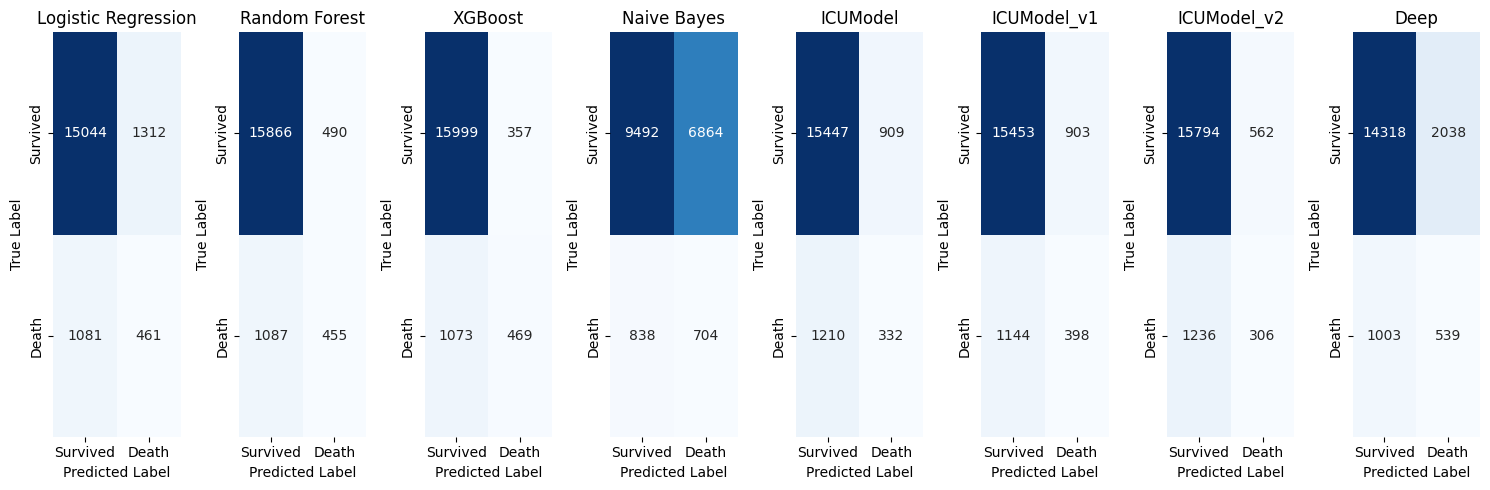

In [113]:
fig, axes = plt.subplots(1, len(results), figsize=(15, 5))

for i, (model, data) in enumerate(results.items()):
    conf_matrix = np.array(data["Confusion Matrix"])
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(model)
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")
    axes[i].set_xticklabels(["Survived", "Death"])
    axes[i].set_yticklabels(["Survived", "Death"])

plt.tight_layout()
plt.show()

In [116]:
print_classification_report(results1)


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.93       0.92       0.93      16356
   Death (1)      0.26       0.30       0.28       1542

    accuracy                           0.87      17898
   macro avg      0.60       0.61       0.60      17898
weighted avg      0.87       0.87       0.87      17898

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.94       0.97       0.95      16356
   Death (1)      0.48       0.30       0.37       1542

    accuracy                           0.91      17898
   macro avg      0.71       0.63       0.66      17898
weighted avg      0.90       0.91       0.90      17898

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.94       0.98       0.96      16356
   Death (1)      0.57       0.30       0.40       1542

    accuracy                           0.92      17898
   macro avg      0.75       0.64       0.68      178

In [118]:
print_classification_report(results)


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.93       0.92       0.93      16356
   Death (1)      0.26       0.30       0.28       1542

    accuracy                           0.87      17898
   macro avg      0.60       0.61       0.60      17898
weighted avg      0.87       0.87       0.87      17898

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.94       0.97       0.95      16356
   Death (1)      0.48       0.30       0.37       1542

    accuracy                           0.91      17898
   macro avg      0.71       0.63       0.66      17898
weighted avg      0.90       0.91       0.90      17898

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.94       0.98       0.96      16356
   Death (1)      0.57       0.30       0.40       1542

    accuracy                           0.92      17898
   macro avg      0.75       0.64       0.68      178


# # RQ 2: 

How does model performance compare to traditional clinical scoring systems (apache_4a_hospital_death_prob, apache_4a_icu_death_prob) for ICU mortality prediction?